In [15]:
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from tuned_lens.data import chunk_and_tokenize, silence_datasets_messages
import torch as th

def load_stuff(name, device = 'cuda:2'):
    model = AutoModelForCausalLM.from_pretrained(
        name, torch_dtype="auto"
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained(name)

    dataset = Dataset.from_json("/mnt/ssd-1/nora/lens-train.jsonl")
    assert isinstance(dataset, Dataset)
    silence_datasets_messages()

    dataset = chunk_and_tokenize(dataset, tokenizer)
    return model, tokenizer, dataset

pythia, pythia_tokenizer, pythia_data = load_stuff(
    "bigscience/bloom-560m"
)

name = "EleutherAI/pythia-13b-deduped"
config = AutoConfig.from_pretrained(name)
tokenizer = AutoTokenizer.from_pretrained(name)

dataset = Dataset.from_json("/mnt/ssd-1/nora/lens-train.jsonl")
assert isinstance(dataset, Dataset)
silence_datasets_messages()

dataset = chunk_and_tokenize(dataset, tokenizer)

In [17]:
import torch as th

counts = th.ones(config.vocab_size, dtype=th.long)

def count_fn(x):
    global counts
    counts += th.bincount(x['input_ids'], minlength=config.vocab_size)

dataset.map(count_fn)

  0%|          | 0/147956 [00:00<?, ?ex/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
    num_rows: 147956
})

In [ ]:
stats_13b = th.load("/mnt/ssd-1/nora/real-lenses/pythia/13b-deduped/affine/eval/final_logit_stats.pt")
stats_125m = th.load("/mnt/ssd-1/nora/real-lenses/pythia/125m-deduped/affine/eval/final_logit_stats.pt")

In [21]:
import math
from tuned_lens.stats import kl_divergence

kl_divergence(
    stats_13b.marginal_probs[:50304].log(),
    stats_125m.marginal_probs[:50304].log()
) / math.log(2)

tensor(0.0068, device='cuda:0')

In [ ]:
from tuned_lens.stats import kl_divergence

empirical_probs = counts / counts.sum()
kl_divergence(empirical_probs, stats.marginal_probs.log().cpu()) * 0.3656547963619232

tensor(0.7195)

In [ ]:
from tuned_lens import TunedLens

lens = TunedLens.load(
    "/mnt/ssd-1/nora/real-lenses/bloom/560m/affine"
).to("cuda:2")

In [ ]:
from tqdm.auto import tqdm
from tuned_lens.nn import Decoder

alphas = []
kls = []
dec = Decoder(pythia)

with th.autocast("cuda"), th.no_grad():
    tokens = pythia_data[:5]["input_ids"].to('cuda:2')
    outputs = pythia(tokens, output_hidden_states=True)
    hiddens = [
        lens.transform_hidden(h, i)
        for i, h in enumerate(outputs.hidden_states[:-1])
    ]

p_f = outputs.logits.double().softmax(-1)
dirac = th.zeros_like(p_f)
dirac.scatter_(-1, tokens[..., None], 1)

for h in tqdm(hiddens):
    ll_log_probs = dec(h).log_softmax(-1)
    ll_probs = ll_log_probs.exp()

    logit_alpha = th.nn.Parameter(p_f.new_tensor(0.0, dtype=th.double))
    opt = th.optim.LBFGS(
        [logit_alpha],
        line_search_fn="strong_wolfe",
        max_iter=100,
        tolerance_change=1e-4,
    )
    kl = th.inf

    def closure():
        global kl
        opt.zero_grad()

        alpha = logit_alpha.sigmoid()
        mixture = p_f.mul(alpha) + (1 - alpha) * dirac
        H_p = -th.sum(mixture * mixture.log(), dim=-1).mean()
        H_p_q = -th.sum(mixture * ll_log_probs, dim=-1).mean()
    
        kl = H_p_q - H_p
        kl.backward()
        return kl

    opt.step(closure)   # type: ignore
    alphas.append(logit_alpha.sigmoid().item())
    kls.append(float(kl))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_2082083/3706532726.py:16 in <module>                                              │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2082083/3706532726.py'                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
OutOfMemoryError: CUDA out of memory. Tried to allocate 19.14 GiB (GPU 2; 47.35 GiB total capacity; 30.31 GiB 
already allocated; 15.69 GiB free; 30.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated 
memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and 
PYTORCH_CUDA_ALLOC_CONF

Text(0, 0.5, 'Mixture weight')

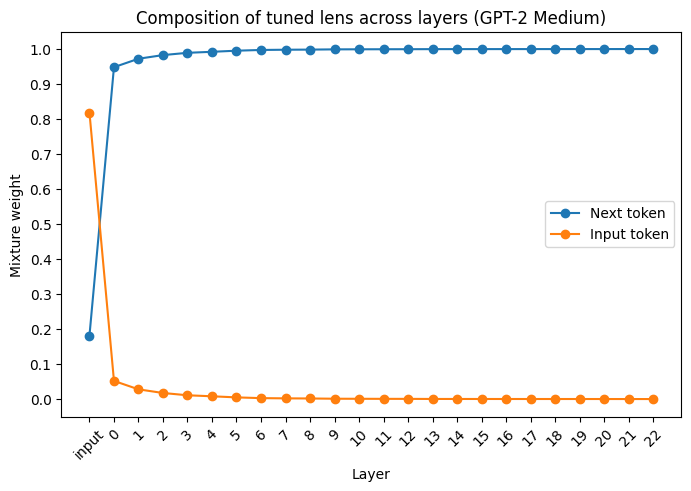

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(alphas, marker='o', label="Next token")
plt.plot([1 - a for a in alphas], marker='o', label="Input token")
plt.legend()
plt.title("Composition of tuned lens across layers (GPT-2 Medium)")
plt.xticks(
    range(len(alphas)),
    labels=["input"] + [str(i) for i in range(len(alphas) - 1)],
    rotation=45,
)
plt.xlabel("Layer")
plt.yticks(
    th.linspace(0, 1, 11),
    labels=[f"{x:.1f}" for x in th.linspace(0, 1, 11)],
)
plt.ylabel("Mixture weight")

In [79]:
opt_agg = th.load(
    "/mnt/ssd-1/nora/real-lenses/bloom/560m/affine/eval/aggregate_metrics.pt",
    map_location="cpu"
)

In [80]:
import plotly.express as px

import plotly.graph_objects as go

fig = go.Figure([
    go.Scatter(
        y=list(opt_agg['baseline_ce'].values()),
        mode="lines+markers",
        name="Logit",
    ),
    go.Scatter(
        y=list(opt_agg['lens_ce'].values()),
        mode="lines+markers",
        name="Tuned<br>(ours)",
    ),
]).update_layout(
    hovermode="x unified",
    legend_title="Lens",
    yaxis_range=[0, 5],
    title="Perplexity (OPT 1.3B)",
    xaxis_title="Layer",
    yaxis_title="KL w.r.t. final layer (bits)",
)
fig

In [75]:
import plotly.express as px

import plotly.graph_objects as go

fig = go.Figure([
    go.Scatter(
        y=list(neo_agg['baseline_ce'].values()),
        mode="lines+markers",
        name="Logit",
    ),
    go.Scatter(
        y=list(neo_agg['lens_ce'].values()),
        mode="lines+markers",
        name="Tuned<br>(ours)",
    ),
]).update_layout(
    hovermode="x unified",
    legend_title="Lens",
    title="Perplexity (GPT Neo 2.7B)",
    xaxis_title="Layer",
    yaxis_title="KL w.r.t. final layer (bits)",
)
fig

In [6]:
def entropy(p):
    return -th.sum(p * p.log(), dim=-1)

In [2]:
from tuned_lens.stats import spearmanr
import torch as th

final_marginals = th.load("/mnt/ssd-1/nora/real-lenses/gpt-neo/2.7B/extra-layer/eval/final_logit_stats.pt").marginal_probs

In [3]:
from tuned_lens.stats import LogitStats
import torch as th

ll_statistics = th.load("/mnt/ssd-1/nora/real-lenses/gpt-neo/2.7B/extra-layer/eval/ll_logit_stats.pt")
tl_statistics = th.load("/mnt/ssd-1/nora/real-lenses/gpt-neo/2.7B/extra-layer/eval/tl_logit_stats.pt")

In [4]:
import math
from tuned_lens.stats import kl_divergence

ll_kls = [
    kl_divergence(final_marginals.log(), s.marginal_probs.log()).item() / math.log(2)
    for s in ll_statistics
]
tl_kls = [
    kl_divergence(final_marginals.log(), s.marginal_probs.log()).item() / math.log(2)
    for s in tl_statistics
]

In [17]:
import plotly.express as px
import plotly.graph_objects as go

TEXT_WIDTH = 6.75 * 96

fig = go.Figure([
    go.Scatter(
        y=ll_kls[:-1],
        marker_color="red",
        marker_symbol="square",
        mode="lines+markers",
        name="Logit lens",
    ),
    go.Scatter(
        y=tl_kls[:-1],
        marker_color="blue",
        marker_symbol="circle",
        mode="lines+markers",
        name="Tuned lens",
    ),
]).update_layout(
    font=dict(color="black", size=16),
    height=TEXT_WIDTH / 2,
    width=TEXT_WIDTH,

    legend=dict(
        x=0.775,
    ),

    hovermode="x unified",
    xaxis_title="Layer",
    yaxis_title="KL (bits)",
    margin_l=70,
    margin_r=30,
    margin_t=50,
    margin_b=70,
).update_xaxes(
    ticktext=["input"] + [str(i * 5) for i in range(1, len(ll_kls) - 1)],
    tickvals=list(range(0, len(ll_kls), 5)),
)
fig

In [19]:
fig.write_image("/mnt/ssd-1/nora/bias-neo-2_7b.pdf")

In [5]:
import torch as th

alignments = th.load(
    "/mnt/ssd-1/nora/real-lenses/pythia/13b-deduped/affine/eval/grad_alignments.pt",
    map_location="cpu",
)

In [11]:
from tuned_lens.utils import pytree_cat

foo = [
    [[th.tensor([4, 0]), th.tensor([5, 0]), th.tensor([6, 0])]],
    [[th.tensor([1, 0]), th.tensor([2, 0]), th.tensor([3, 0])]],
]
pytree_cat(foo)

[[tensor([4, 0, 1, 0]), tensor([5, 0, 2, 0]), tensor([6, 0, 3, 0])]]

In [12]:
alignments.chunk(8)

(tensor([-0.0091, -0.0073, -0.0140,  ..., -0.0251, -0.0287, -0.0070]),
 tensor([-0.0082, -0.0078, -0.0150,  ..., -0.0250, -0.0293, -0.0078]),
 tensor([-0.0092, -0.0058, -0.0158,  ..., -0.0246, -0.0299, -0.0154]),
 tensor([-0.0109, -0.0078, -0.0182,  ..., -0.0200, -0.0291, -0.0132]),
 tensor([-0.0118, -0.0062, -0.0169,  ..., -0.0185, -0.0300, -0.0121]),
 tensor([-0.0096, -0.0076, -0.0169,  ..., -0.0174, -0.0276, -0.0114]),
 tensor([-0.0106, -0.0082, -0.0152,  ..., -0.0237, -0.0304, -0.0143]),
 tensor([-0.0113, -0.0070, -0.0147,  ..., -0.0162, -0.0265, -0.0136]))

In [20]:
alignments.reshape(8, -1, 36).flatten(0, 1).median(dim=0).values

tensor([-0.0123, -0.0082, -0.0171, -0.0069, -0.0128, -0.0170, -0.0240, -0.0152,
        -0.0156, -0.0121, -0.0052, -0.0092, -0.0090, -0.0065, -0.0081, -0.0039,
        -0.0068, -0.0076, -0.0037, -0.0021, -0.0122, -0.0243, -0.0140, -0.0218,
        -0.0204, -0.0210, -0.0267, -0.0161, -0.0176, -0.0145, -0.0135, -0.0159,
        -0.0162, -0.0195, -0.0289, -0.0112])

In [55]:
fig.write_image("/mnt/ssd-1/nora/bias-pythia-13b.pdf")

In [39]:
[
    tokenizer.convert_ids_to_tokens(
        th.abs(s.marginal_probs.log() - final_marginals.log()).topk(15).indices.cpu()
    ) for s in ll_statistics]

[['Ġcombined',
  'ĠMac',
  'ĠGoogle',
  'Ġcost',
  'ĠApple',
  'ĠOS',
  'ĠCaptain',
  'ĠMiss',
  'ĠWindows',
  'Ġill',
  'ĠAustralia',
  'Ġfun',
  'ĠSpirit',
  'ĠFederation',
  'ĠBill'],
 ['ĠTanz',
  'Ġhorizont',
  'berra',
  'arij',
  'ĠAirl',
  'etsk',
  'oided',
  'ĠunfocusedRange',
  'ĠCosponsors',
  'waukee',
  'phrine',
  'psons',
  'riors',
  'ĠEnix',
  'Ġveter'],
 ['ĠTanz',
  'Ġhorizont',
  'berra',
  'ĠunfocusedRange',
  'oided',
  'enegger',
  'etsk',
  'riors',
  'ĠEnix',
  'ĠCosponsors',
  'phrine',
  'merce',
  'oice',
  'ainers',
  'ĠChaser'],
 ['Ġhorizont',
  'ĠTanz',
  'ĠunfocusedRange',
  'ĠEnix',
  'berra',
  'oided',
  'enegger',
  'ainers',
  'etsk',
  'soever',
  'oice',
  'phrine',
  'chery',
  'rences',
  'orative'],
 ['ĠunfocusedRange',
  'vertisement',
  'Ġhorizont',
  'ĠTanz',
  'oided',
  'berra',
  'ĠEnix',
  'etsk',
  'ainers',
  'rences',
  'soever',
  'phrine',
  'orative',
  'chery',
  'ariat'],
 ['ĠunfocusedRange',
  'vertisement',
  'oided',
  'Ġhorizo

In [4]:
alphas

[2.558381765993545e-06,
 0.024947553873062134,
 0.3169231712818146,
 0.7165943384170532,
 0.9252972602844238,
 0.9809284806251526,
 0.997351884841919,
 0.9994321465492249,
 0.9999240636825562,
 0.9999603033065796,
 0.9999722242355347,
 0.999971866607666]

In [19]:
kls

[9.32862663269043,
 9.24746322631836,
 9.33458423614502,
 10.17176342010498,
 10.684821128845215,
 10.828119277954102,
 9.086590766906738,
 9.425753593444824,
 9.75611400604248,
 10.43419075012207]